# Building and Running Complete Workflows

This notebook demonstrates how to build and run complete workflows with the NeuroWorkflow library. We'll create a comprehensive neural simulation and analysis workflow that includes:

1. Network building
2. Simulation
3. Spike train analysis
4. Data filtering
5. Visualization

## Setup

First, let's import the necessary components and set up our environment.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Add the src directory to the Python path if needed
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import NeuroWorkflow components
from neuroworkflow import Node, NodeDefinitionSchema, WorkflowBuilder
from neuroworkflow.core.schema import PortDefinition, ParameterDefinition, MethodDefinition
from neuroworkflow.core.port import PortType
from neuroworkflow.nodes.network import BuildSonataNetworkNode
from neuroworkflow.nodes.simulation import SimulateSonataNetworkNode
from neuroworkflow.nodes.analysis import SpikeAnalysisNode

# Import the DataFilterNode from the previous notebook
# Uncomment this line if you want to run the previous notebook instead of using the definition below
# %run 03_Creating_Custom_Nodes.ipynb

# Define DataFilterNode class directly in this notebook
class DataFilterNode(Node):
    """Node for filtering time series data."""
    
    NODE_DEFINITION = NodeDefinitionSchema(
        type='data_filter',
        description='Filters time series data using various methods',
        
        # Define configurable parameters
        parameters={
            'filter_type': ParameterDefinition(
                default_value='moving_average',
                description='Type of filter to apply',
                constraints={'allowed_values': ['moving_average', 'gaussian', 'median', 'butterworth']}
            ),
            'window_size': ParameterDefinition(
                default_value=5,
                description='Window size for moving average and median filters',
                constraints={'min': 1, 'max': 1000}
            ),
            'sigma': ParameterDefinition(
                default_value=1.0,
                description='Standard deviation for Gaussian filter',
                constraints={'min': 0.1, 'max': 100.0}
            ),
            'cutoff_freq': ParameterDefinition(
                default_value=0.1,
                description='Cutoff frequency for Butterworth filter (normalized to Nyquist)',
                constraints={'min': 0.001, 'max': 0.999}
            ),
            'order': ParameterDefinition(
                default_value=4,
                description='Order for Butterworth filter',
                constraints={'min': 1, 'max': 10}
            )
        },
        
        # Define input ports
        inputs={
            'data': PortDefinition(
                type=PortType.OBJECT,  # We'll accept numpy arrays or lists
                description='Time series data to filter'
            ),
            'sampling_rate': PortDefinition(
                type=PortType.FLOAT,
                description='Sampling rate of the data (Hz)',
                optional=True  # This is optional
            )
        },
        
        # Define output ports
        outputs={
            'filtered_data': PortDefinition(
                type=PortType.OBJECT,
                description='Filtered time series data'
            ),
            'filter_info': PortDefinition(
                type=PortType.DICT,
                description='Information about the applied filter'
            )
        },
        
        # Define methods
        methods={
            'apply_filter': MethodDefinition(
                description='Apply the selected filter to the data',
                inputs=['data', 'sampling_rate'],
                outputs=['filtered_data', 'filter_info']
            )
        }
    )
    
    def __init__(self, name):
        """Initialize the DataFilterNode.
        
        Args:
            name: Name of the node
        """
        super().__init__(name)
        self._define_process_steps()
    
    def _define_process_steps(self):
        """Define the process steps for this node."""
        self.add_process_step(
            "apply_filter",
            self.apply_filter,
            method_key="apply_filter"
        )
    
    def apply_filter(self, data, sampling_rate=None):
        """Apply the selected filter to the data.
        
        Args:
            data: Time series data to filter (numpy array or list)
            sampling_rate: Sampling rate of the data (Hz), optional
            
        Returns:
            Dictionary with filtered data and filter information
        """
        # Convert data to numpy array if it's not already
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        
        # Get filter parameters
        filter_type = self._parameters['filter_type']
        window_size = self._parameters['window_size']
        sigma = self._parameters['sigma']
        cutoff_freq = self._parameters['cutoff_freq']
        order = self._parameters['order']
        
        print(f"Applying {filter_type} filter to data of length {len(data)}")
        
        # Apply the selected filter
        if filter_type == 'moving_average':
            filtered_data = self._apply_moving_average(data, window_size)
            filter_info = {
                'type': 'moving_average',
                'window_size': window_size
            }
        
        elif filter_type == 'gaussian':
            filtered_data = self._apply_gaussian(data, sigma)
            filter_info = {
                'type': 'gaussian',
                'sigma': sigma
            }
        
        elif filter_type == 'median':
            filtered_data = self._apply_median(data, window_size)
            filter_info = {
                'type': 'median',
                'window_size': window_size
            }
        
        elif filter_type == 'butterworth':
            if sampling_rate is None:
                print("Warning: No sampling rate provided for Butterworth filter. Using default of 1.0 Hz.")
                sampling_rate = 1.0
            
            filtered_data = self._apply_butterworth(data, cutoff_freq, order, sampling_rate)
            filter_info = {
                'type': 'butterworth',
                'cutoff_freq': cutoff_freq,
                'order': order,
                'sampling_rate': sampling_rate
            }
        
        else:
            raise ValueError(f"Unknown filter type: {filter_type}")
        
        # Add some statistics to the filter info
        filter_info.update({
            'original_mean': np.mean(data),
            'original_std': np.std(data),
            'filtered_mean': np.mean(filtered_data),
            'filtered_std': np.std(filtered_data)
        })
        
        return {
            'filtered_data': filtered_data,
            'filter_info': filter_info
        }
    
    def _apply_moving_average(self, data, window_size):
        """Apply moving average filter."""
        kernel = np.ones(window_size) / window_size
        return np.convolve(data, kernel, mode='same')

    def _apply_gaussian(self, data, sigma):
        """Apply Gaussian filter."""
        # Create Gaussian kernel
        window_size = int(6 * sigma)  # 3 sigma on each side
        if window_size % 2 == 0:
            window_size += 1  # Make sure it's odd
        
        x = np.linspace(-3*sigma, 3*sigma, window_size)
        kernel = np.exp(-0.5 * (x/sigma)**2)
        kernel = kernel / np.sum(kernel)  # Normalize
        
        return np.convolve(data, kernel, mode='same')

    def _apply_median(self, data, window_size):
        """Apply median filter."""
        from scipy.signal import medfilt
        # Make sure window_size is odd
        if window_size % 2 == 0:
            window_size += 1
        
        return medfilt(data, kernel_size=window_size)

    def _apply_butterworth(self, data, cutoff_freq, order, sampling_rate):
        """Apply Butterworth filter."""
        from scipy.signal import butter, filtfilt
        
        # Normalize cutoff frequency
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        
        # Create filter
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        
        # Apply filter
        return filtfilt(b, a, data)

## Creating a Visualization Node

Let's create a visualization node to display the results of our analysis:

In [2]:
class VisualizationNode(Node):
    """Node for visualizing neural data."""
    
    NODE_DEFINITION = NodeDefinitionSchema(
        type='visualization',
        description='Visualizes neural data',
        
        parameters={
            'figure_size': ParameterDefinition(
                default_value=(10, 6),
                description='Figure size (width, height) in inches'
            ),
            'save_figures': ParameterDefinition(
                default_value=False,
                description='Whether to save figures to disk'
            ),
            'output_dir': ParameterDefinition(
                default_value='./figures',
                description='Directory to save figures'
            )
        },
        
        inputs={
            'spike_data': PortDefinition(
                type=PortType.OBJECT,
                description='Spike data to visualize',
                optional=True
            ),
            'firing_rates': PortDefinition(
                type=PortType.DICT,
                description='Firing rates to visualize',
                optional=True
            ),
            'isi_histograms': PortDefinition(
                type=PortType.DICT,
                description='ISI histograms to visualize',
                optional=True
            ),
            'filtered_data': PortDefinition(
                type=PortType.OBJECT,
                description='Filtered data to visualize',
                optional=True
            )
        },
        
        outputs={
            'figures': PortDefinition(
                type=PortType.DICT,
                description='Dictionary of generated figures'
            ),
            'figure_paths': PortDefinition(
                type=PortType.DICT,
                description='Paths to saved figures'
            )
        },
        
        methods={
            'visualize_data': MethodDefinition(
                description='Visualize the input data',
                inputs=['spike_data', 'firing_rates', 'isi_histograms', 'filtered_data'],
                outputs=['figures', 'figure_paths']
            )
        }
    )
    
    def __init__(self, name):
        """Initialize the VisualizationNode."""
        super().__init__(name)
        self._define_process_steps()
    
    def _define_process_steps(self):
        """Define the process steps for this node."""
        self.add_process_step(
            "visualize_data",
            self.visualize_data,
            method_key="visualize_data"
        )
    
    def visualize_data(self, spike_data=None, firing_rates=None, isi_histograms=None, filtered_data=None):
        """Visualize the input data.
        
        Args:
            spike_data: Spike data to visualize
            firing_rates: Firing rates to visualize
            isi_histograms: ISI histograms to visualize
            filtered_data: Filtered data to visualize
            
        Returns:
            Dictionary with figures and figure paths
        """
        figures = {}
        figure_paths = {}
        
        # Get parameters
        figure_size = self._parameters['figure_size']
        save_figures = self._parameters['save_figures']
        output_dir = self._parameters['output_dir']
        
        # Create output directory if saving figures
        if save_figures and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Visualize spike data
        if spike_data is not None:
            fig = plt.figure(figsize=figure_size)
            
            # Extract spike times and neuron IDs
            if isinstance(spike_data, dict) and 'data' in spike_data:
                times = spike_data['data'].get('times', [])
                senders = spike_data['data'].get('senders', [])
            else:
                # Try to handle other formats
                times = getattr(spike_data, 'times', [])
                senders = getattr(spike_data, 'senders', [])
            
            plt.scatter(times, senders, marker='|', s=100, color='black')
            plt.xlabel('Time (ms)')
            plt.ylabel('Neuron ID')
            plt.title('Spike Trains')
            plt.grid(True, alpha=0.3)
            
            figures['spike_trains'] = fig
            
            if save_figures:
                path = os.path.join(output_dir, 'spike_trains.png')
                fig.savefig(path)
                figure_paths['spike_trains'] = path
        
        # Visualize firing rates
        if firing_rates is not None:
            fig = plt.figure(figsize=figure_size)
            
            neuron_ids = sorted(firing_rates.keys())
            rates = [firing_rates[nid] for nid in neuron_ids]
            
            plt.bar(neuron_ids, rates)
            plt.xlabel('Neuron ID')
            plt.ylabel('Firing Rate (Hz)')
            plt.title('Firing Rates by Neuron')
            plt.grid(True, alpha=0.3)
            
            figures['firing_rates'] = fig
            
            if save_figures:
                path = os.path.join(output_dir, 'firing_rates.png')
                fig.savefig(path)
                figure_paths['firing_rates'] = path
        
        # Visualize ISI histograms
        if isi_histograms is not None and isi_histograms:
            n_neurons = len(isi_histograms)
            fig, axes = plt.subplots(n_neurons, 1, figsize=(figure_size[0], figure_size[1] * n_neurons / 2))
            
            if n_neurons == 1:
                axes = [axes]  # Make it iterable
            
            for i, (neuron_id, hist_data) in enumerate(sorted(isi_histograms.items())):
                if not hist_data.get('counts', []):
                    axes[i].text(0.5, 0.5, 'No ISI data available', 
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 transform=axes[i].transAxes)
                else:
                    # Plot histogram
                    bin_edges = hist_data.get('bin_edges', [])
                    counts = hist_data.get('counts', [])
                    if len(bin_edges) > len(counts):
                        bin_edges = bin_edges[:-1]  # Remove last edge
                    
                    if len(bin_edges) == len(counts):
                        width = bin_edges[1] - bin_edges[0] if len(bin_edges) > 1 else 1
                        axes[i].bar(bin_edges, counts, width=width, alpha=0.7, align='edge')
                    
                    # Add mean ISI line
                    mean_isi = hist_data.get('mean_isi', 0)
                    if mean_isi > 0:
                        axes[i].axvline(mean_isi, color='r', linestyle='--', 
                                        label=f'Mean: {mean_isi:.2f} ms')
                        axes[i].legend()
                
                axes[i].set_title(f'Neuron {neuron_id} - ISI Histogram')
                axes[i].set_ylabel('Count')
                axes[i].grid(True, alpha=0.3)
            
            axes[-1].set_xlabel('Inter-Spike Interval (ms)')
            plt.tight_layout()
            
            figures['isi_histograms'] = fig
            
            if save_figures:
                path = os.path.join(output_dir, 'isi_histograms.png')
                fig.savefig(path)
                figure_paths['isi_histograms'] = path
        
        # Visualize filtered data
        if filtered_data is not None:
            fig = plt.figure(figsize=figure_size)
            
            if isinstance(filtered_data, np.ndarray):
                plt.plot(filtered_data)
                plt.xlabel('Sample')
                plt.ylabel('Value')
                plt.title('Filtered Data')
                plt.grid(True, alpha=0.3)
                
                figures['filtered_data'] = fig
                
                if save_figures:
                    path = os.path.join(output_dir, 'filtered_data.png')
                    fig.savefig(path)
                    figure_paths['filtered_data'] = path
        
        return {
            'figures': figures,
            'figure_paths': figure_paths
        }

## Creating a Complete Workflow

Now let's create a complete workflow that includes all the nodes we've created:

In [3]:
# Create nodes
build_network = BuildSonataNetworkNode("NetworkBuilder")
build_network.configure(
    sonata_path="/path/to/sonata/config",
    net_config_file="circuit_config.json",
    hdf5_hyperslab_size=1024
)

simulate_network = SimulateSonataNetworkNode("NetworkSimulator")
simulate_network.configure(
    simulation_time=1000.0,
    record_from_population="excitatory",
    record_n_neurons=10
)

spike_analyzer = SpikeAnalysisNode("SpikeAnalyzer")
spike_analyzer.configure(
    time_window=[0.0, 1000.0],
    bin_size=5.0,
    metrics=['rate', 'isi']
)

data_filter = DataFilterNode("DataFilter")
data_filter.configure(
    filter_type='gaussian',
    sigma=2.0
)

visualizer = VisualizationNode("Visualizer")
visualizer.configure(
    figure_size=(12, 8),
    save_figures=True,
    output_dir="./workflow_figures"
)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Mar  4 2025 17:27:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [4]:
# Create a workflow builder
workflow_builder = WorkflowBuilder("neural_simulation_workflow")

# Add nodes to the workflow
workflow_builder.add_node(build_network)
workflow_builder.add_node(simulate_network)
workflow_builder.add_node(spike_analyzer)
workflow_builder.add_node(data_filter)
workflow_builder.add_node(visualizer)

# Connect the nodes
# Network building -> Simulation
workflow_builder.connect("NetworkBuilder", "sonata_net", "NetworkSimulator", "sonata_net")
workflow_builder.connect("NetworkBuilder", "node_collections", "NetworkSimulator", "node_collections")

# Simulation -> Spike Analysis
# Note: In a real workflow, we would connect the spike recorder to the spike analyzer
# Here we'll use a dummy connection and set the spike data manually

# Spike Analysis -> Data Filter (we'll filter the firing rates)
workflow_builder.connect("SpikeAnalyzer", "firing_rates", "DataFilter", "data")

# Connect outputs to the visualizer
workflow_builder.connect("SpikeAnalyzer", "firing_rates", "Visualizer", "firing_rates")
workflow_builder.connect("SpikeAnalyzer", "isi_histograms", "Visualizer", "isi_histograms")
workflow_builder.connect("DataFilter", "filtered_data", "Visualizer", "filtered_data")

# Build the workflow
workflow = workflow_builder.build()

# Print workflow information
print(workflow)

Workflow: neural_simulation_workflow
Nodes:
  NetworkBuilder
  NetworkSimulator
  SpikeAnalyzer
  DataFilter
  Visualizer
Connections:
  NetworkBuilder.sonata_net -> NetworkSimulator.sonata_net
  NetworkBuilder.node_collections -> NetworkSimulator.node_collections
  SpikeAnalyzer.firing_rates -> DataFilter.data
  SpikeAnalyzer.firing_rates -> Visualizer.firing_rates
  SpikeAnalyzer.isi_histograms -> Visualizer.isi_histograms
  DataFilter.filtered_data -> Visualizer.filtered_data


## Visualizing the Workflow

Let's visualize the workflow structure using NetworkX:

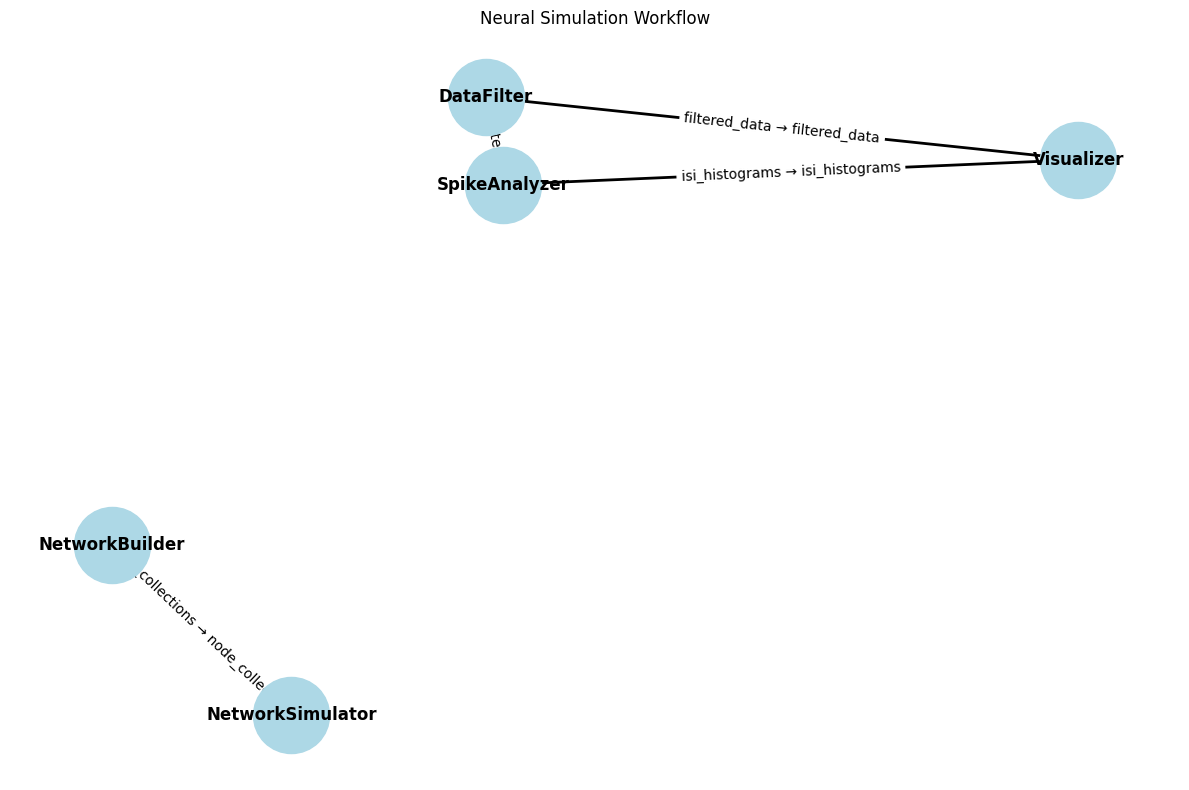

In [5]:
try:
    import networkx as nx
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for node_name in workflow.nodes:
        G.add_node(node_name)
    
    # Add edges for connections
    for conn in workflow.connections:
        G.add_edge(
            conn.from_node, 
            conn.to_node, 
            label=f"{conn.from_port} → {conn.to_port}"
        )
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, arrowsize=20)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    
    # Draw edge labels
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title("Neural Simulation Workflow")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("NetworkX not installed. Install with: pip install networkx")

## Generating Sample Data

Since we don't have actual SONATA data, let's generate some sample spike data to use in our workflow:

In [6]:
def generate_sample_spike_data(n_neurons=10, duration=1000.0):
    """Generate sample spike data for testing."""
    # Generate random rates between 5-25 Hz
    rates = [random.uniform(5, 25) for _ in range(n_neurons)]
    
    # Generate spike times for each neuron
    spike_times = []
    neuron_ids = []
    
    for neuron_id, rate in enumerate(rates, 1):
        # Expected number of spikes in the time window
        expected_spikes = rate * duration / 1000.0
        # Generate random spike times using Poisson process
        n_spikes = np.random.poisson(expected_spikes)
        times = np.sort(np.random.uniform(0, duration, n_spikes))
        
        spike_times.extend(times)
        neuron_ids.extend([neuron_id] * len(times))
    
    # Sort by time
    indices = np.argsort(spike_times)
    spike_times = np.array(spike_times)[indices]
    neuron_ids = np.array(neuron_ids)[indices]
    
    return {
        "format": "spike_recorder",
        "data": {
            "times": spike_times.tolist(),
            "senders": neuron_ids.tolist()
        },
        "metadata": {
            "n_neurons": n_neurons,
            "duration": duration,
            "rates": rates
        }
    }

# Generate sample spike data
sample_spike_data = generate_sample_spike_data(10, 1000.0)

## Executing the Workflow

Now let's execute the workflow with our sample data:

In [7]:
# Set the spike data for the spike analyzer
spike_analyzer.get_input_port("spike_data").set_value(sample_spike_data)

# Set sampling rate for the data filter
data_filter.get_input_port("sampling_rate").set_value(100.0)

# Execute the workflow
print("Executing workflow...")
success = workflow.execute()

if success:
    print("\nWorkflow execution completed successfully!")
    
    # Get the visualization results
    figures = visualizer.get_output_port("figures").value
    figure_paths = visualizer.get_output_port("figure_paths").value
    
    print("\nGenerated figures:")
    for name in figures.keys():
        print(f"  {name}")
    
    if figure_paths:
        print("\nSaved figures to:")
        for name, path in figure_paths.items():
            print(f"  {name}: {path}")
else:
    print("\nWorkflow execution failed!")

Executing workflow...
Executing node: SpikeAnalyzer
Extracting spikes from recorder data
Analyzing 10 neurons in time window [0.0, 1000.0] ms
Calculating metrics: ['rate', 'isi']
Generating analysis report
Executing node: DataFilter
Error executing process step 'apply_filter' in node 'DataFilter': len() of unsized object
Error executing node: DataFilter

Workflow execution failed!


## Displaying the Results

Let's display the figures generated by the workflow:

No figures available from workflow execution.
Generating sample figure for demonstration...


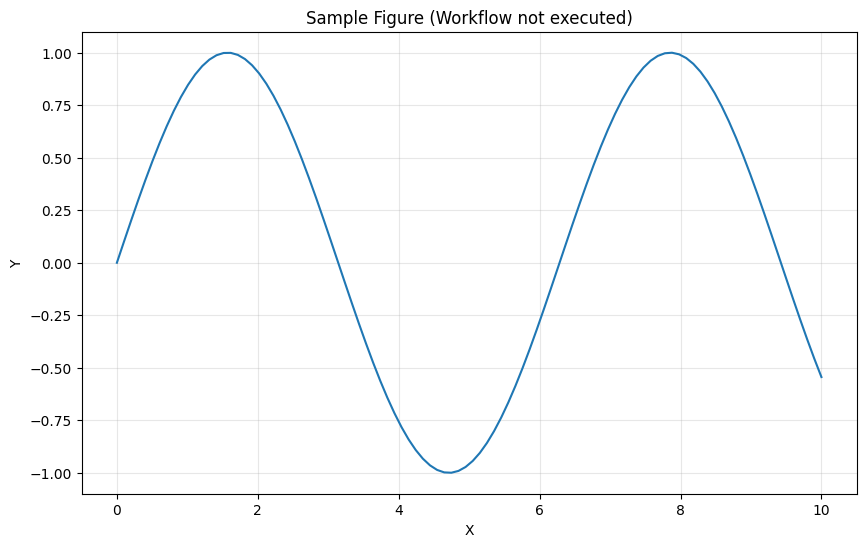

In [8]:
# Display the figures if they exist
# Note: This will only work if the workflow has been executed successfully
# and the 'figures' variable has been defined in the previous cell

# Generate some sample data for demonstration if figures don't exist
if 'figures' not in globals():
    print("No figures available from workflow execution.")
    print("Generating sample figure for demonstration...")
    
    # Create a sample figure
    sample_fig = plt.figure(figsize=(10, 6))
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    plt.plot(x, y)
    plt.title("Sample Figure (Workflow not executed)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    # Display the figures from the workflow
    print(f"Displaying {len(figures)} figures from workflow execution...")
    for name, fig in figures.items():
        plt.figure(fig.number)
        plt.title(f"{name} (from workflow)")
        plt.show()

## Saving and Loading Workflows

Let's implement a simple way to save and load workflows:

In [9]:
import json
import pickle

def save_workflow_config(workflow, filename):
    """Save workflow configuration to a JSON file.
    
    Args:
        workflow: Workflow object
        filename: Output filename
    """
    # Create a serializable representation of the workflow
    config = {
        'name': workflow.name,
        'nodes': {},
        'connections': []
    }
    
    # Save node configurations
    for name, node in workflow.nodes.items():
        config['nodes'][name] = {
            'type': node.__class__.__name__,
            'parameters': node._parameters
        }
    
    # Save connections
    for conn in workflow.connections:
        config['connections'].append({
            'from_node': conn.from_node,
            'from_port': conn.from_port,
            'to_node': conn.to_node,
            'to_port': conn.to_port
        })
    
    # Save to file
    with open(filename, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Workflow configuration saved to {filename}")

def save_workflow(workflow, filename):
    """Save complete workflow to a pickle file.
    
    Args:
        workflow: Workflow object
        filename: Output filename
    """
    with open(filename, 'wb') as f:
        pickle.dump(workflow, f)
    
    print(f"Workflow saved to {filename}")

def load_workflow(filename):
    """Load workflow from a pickle file.
    
    Args:
        filename: Input filename
        
    Returns:
        Loaded workflow
    """
    with open(filename, 'rb') as f:
        workflow = pickle.load(f)
    
    print(f"Workflow loaded from {filename}")
    return workflow

In [10]:
# Save the workflow configuration
save_workflow_config(workflow, 'neural_workflow_config.json')

# Save the complete workflow
save_workflow(workflow, 'neural_workflow.pkl')

Workflow configuration saved to neural_workflow_config.json
Workflow saved to neural_workflow.pkl


In [11]:
# Load the workflow
loaded_workflow = load_workflow('neural_workflow.pkl')

# Print workflow information
print(loaded_workflow)

Workflow loaded from neural_workflow.pkl
Workflow: neural_simulation_workflow
Nodes:
  NetworkBuilder
  NetworkSimulator
  SpikeAnalyzer
  DataFilter
  Visualizer
Connections:
  NetworkBuilder.sonata_net -> NetworkSimulator.sonata_net
  NetworkBuilder.node_collections -> NetworkSimulator.node_collections
  SpikeAnalyzer.firing_rates -> DataFilter.data
  SpikeAnalyzer.firing_rates -> Visualizer.firing_rates
  SpikeAnalyzer.isi_histograms -> Visualizer.isi_histograms
  DataFilter.filtered_data -> Visualizer.filtered_data
Execution Order:
  SpikeAnalyzer -> DataFilter -> Visualizer -> NetworkBuilder -> NetworkSimulator


## Conclusion

In this notebook, we've demonstrated how to:

1. Create a complete neural simulation and analysis workflow
2. Visualize the workflow structure
3. Execute the workflow with sample data
4. Display and save the results
5. Save and load workflows

This example shows the power and flexibility of the NeuroWorkflow library for creating complex scientific workflows. By connecting different nodes together, you can create sophisticated data processing pipelines that are modular, reusable, and easy to understand.

In a real-world scenario, you would:

1. Create custom nodes for your specific scientific domain
2. Build workflows that match your research questions
3. Execute workflows on real data
4. Analyze and visualize the results
5. Share workflows with colleagues for reproducibility

The NeuroWorkflow library provides a solid foundation for all of these activities, making it easier to conduct complex scientific analyses in a structured and reproducible way.